In [13]:
import sys
import xarray as xr
import glob
import dask
import cartopy.crs as ccrs
import cmocean
import matplotlib.pyplot as plt
import re
import datetime
from functions.grid_to_km import area
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
import numpy as np
%matplotlib inline

In [14]:
sys.path.insert(0,'.')    # '.' is in the same folder
%load_ext autoreload
%autoreload 1
#  Reload all modules imported with %aimport every time before executing the Python code typed.

%cd /home/students/6252699/thesis/parcels2/
%aimport advect_glorys_data_all
%aimport plot_functions






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/students/6252699/thesis/parcels2


In [57]:
import matplotlib as mpl
from matplotlib import rcParams

################################################################
plt.style.use(['classic'])

# plotting parameters
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams["figure.figsize"] = [8 , 4]
mpl.rcParams['legend.fontsize'] = 12      #legend size
#title params
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['font.style'] = 'italic'    #all fonts italic
#axes params
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams["xtick.labelsize"] = 13
mpl.rcParams["ytick.labelsize"] = 13
# line width and grid
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams["axes.grid"] = 1
# mpl.rcParams["figure.subplot.left"] = 0.05
# mpl.rcParams["figure.subplot.right"] = 0.1
# mpl.rcParams["figure.subplot.bottom"] = 0.11
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.pad_inches"] = 0.1
mpl.rcParams['legend.loc'] =  'best'

rcParams['savefig.facecolor']  = "white"    # figure facecolor when saving
# rcParams['savefig.transparent'] = True
# # colors
# COLOR = 'green'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR



In [15]:
def set_axes():
    plt.figure(figsize = [8,8])
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.gridlines(xlocs = np.arange(-180,185,20), ylocs = np.arange(-90, 95,5))
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND)
    ax.set_extent([-180,180,50,90],  ccrs.PlateCarree())
    return ax

# Transition matrix

## Load file

In [41]:
'''Load file'''

everywhere_try2 = "/scratch/AnnekeV/output/everywhere/run_02_19_npart_867407_start_2014-02-01_simdays_35_AdvectionRK4_ice"

ds = xr.open_dataset(everywhere_try1 + ".nc", decode_times=False)

lat_init  = ds.lat.isel(obs=0).values
lon_init  = ds.lon.isel(obs=0).values

lat_final = ds.lat.isel(obs=-1).values
lon_final = ds.lon.isel(obs=-1).values

In [42]:
'''Set parameters'''

nlat = 8
nlon = 12
ncel = nlat*nlon
nparticles = len(lat_init)

latbins = np.linspace(50,90, nlat+1)
lonbins = np.linspace(-180,180,nlon+1)
M = np.zeros((ncel,ncel))


def binned_statistic(x, nbins, range):
    '''The usage is nearly the same as scipy.stats.binned_statistic''' 
    r0, r1 = range
    digitized = (float(nbins)/(r1 - r0)*(x - r0)).astype(int)    
    return digitized




In [319]:
%%time

'''Fill vecotrs and transition matrix'''
R0 = np.zeros(ncel)
M2 = np.zeros((ncel,ncel))

for n in range(nparticles):
    if np.isfinite(lon_init[n]) and np.isfinite(lon_final[n]) and np.isfinite(lat_init[n]) and np.isfinite(lat_final[n]):
        R0 += np.histogram2d([lon_init[n]],[lat_init[n]], bins = [lonbins, latbins])[0].T.flatten()
        j = np.argmax(np.histogram2d([lon_init[n]],[lat_init[n]], bins = [lonbins, latbins])[0].T.flatten())
        i = np.argmax(np.histogram2d([lon_final[n]],[lat_final[n]], bins = [lonbins, latbins])[0].T.flatten())
        M2[i,j] += 1.

for j in range(ncel):
    if np.sum(M2[:,j]>0): M2[:,j] /= np.sum(M2[:,j])
    


CPU times: user 6.99 s, sys: 189 ms, total: 7.18 s
Wall time: 7.33 s


In [336]:
# %%time

M3     = np.zeros((ncel,ncel))
R0_try = np.zeros((nlat,nlon))

lati_dig = binned_statistic(lat_init, nlat,[50,90])
loni_dig = binned_statistic(lon_init, nlon, [50,90])

indices = np.where((lati_dig>=0) & (lati_dig<nlat))

for n in indices:
    print(loni_dig[n])
    if ((loni_dig[n]>-0.01)):# and (loni_dig[n]<nlon)):     
        R0_try[lati_dig[n], loni_dig[n]] +=1


[-69 -69 -69 ...  38  38  38]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

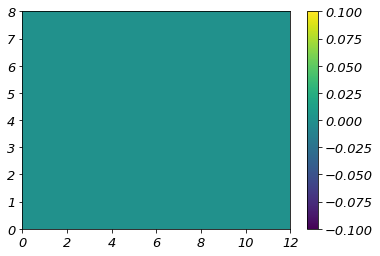

In [326]:
p = plt.pcolormesh(R0_try)
plt.colorbar(p)


Text(0.5,1,'M2')

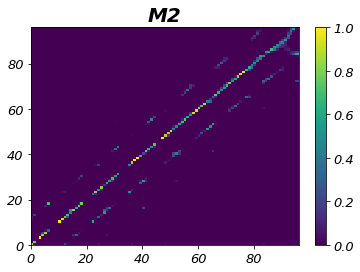

In [243]:
p = plt.pcolormesh(M2)
plt.colorbar(p)
plt.title("M2")

Text(0.5,1,'Intial reshape')

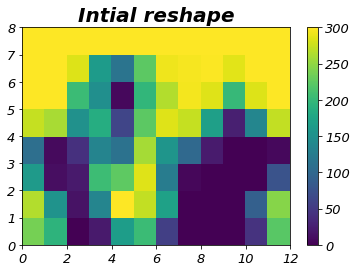

In [275]:
p = plt.pcolormesh( R0.reshape(nlat,nlon))
plt.colorbar(p)
plt.title("Intial reshape")


Text(0.5,1,'Final reshape')

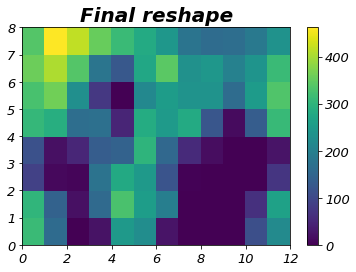

In [278]:
Rt = np.dot(M2,R0.T)

p = plt.pcolormesh( Rt.reshape(nlat,nlon))
plt.colorbar(p)
plt.title("Final reshape")

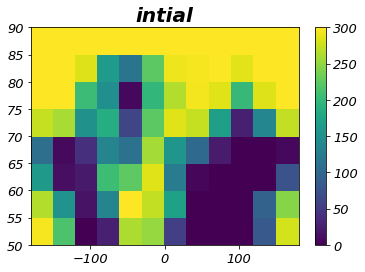

In [246]:
H, xedges, yedges = np.histogram2d(lon_init, lat_init, bins=(np.arange(-180,210,30),np.arange(50,95,5)))
X, Y     = np.meshgrid(xedges, yedges)
H_initial = H.T

p = plt.pcolormesh(X,Y,H_initial)
plt.title("intial")
plt.colorbar(p)


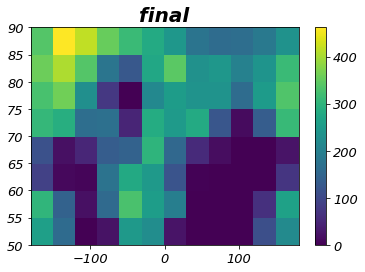

In [146]:
H, xedges, yedges = np.histogram2d(lon_final, lat_final, bins=(np.arange(-180,210,30),np.arange(50,95,5)))
X, Y     = np.meshgrid(xedges, yedges)
H_final = H.T

p = plt.pcolormesh(X,Y,H_final)
plt.title("final")
plt.colorbar(p)


## Plotted on real earth

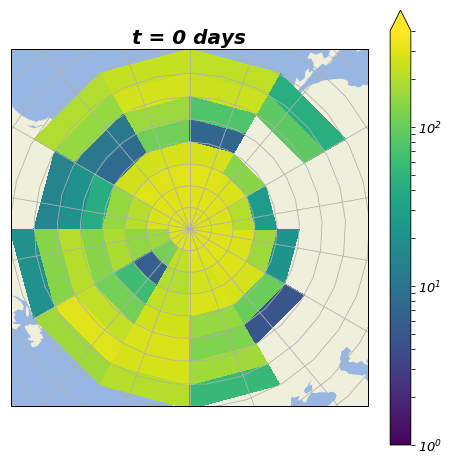

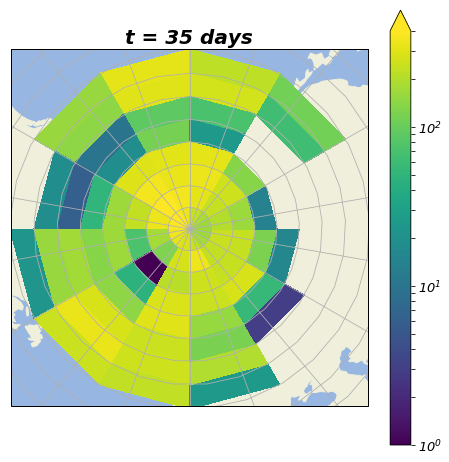

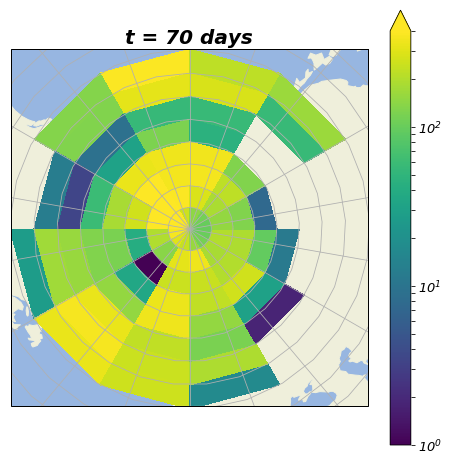

In [283]:
times =3

R = np.zeros((times, ncel))
R[0,:] = R0
R[1,:] = Rt
R[2,:] = np.dot(M2,Rt)

for t in range(times):
    ax = set_axes()
    p  = ax.pcolormesh(X,Y, R[t,:].reshape(nlat,nlon), transform = ccrs.PlateCarree(), norm = mpl.colors.LogNorm(vmin=1,vmax=400))
    ax.figure.colorbar(p, extend = 'max')
    ax.set_title("t = {} days".format(t*35))
    plt.show()


# Function for transition matrix

In [43]:
def trans_mat(res, lon_init, lon_final, lat_init, lat_final):
    '''
    Fill First vector and transition matrix. 
    Res is the resolution, first x (lon) than y(lat), or scalar. lon init the inital longitudes, lat init the initial latitudes etcetera
    Returns M: Transition matrix, R0, intial vector (histogram), edges of bins (lat, lon)
    '''
    
    if np.isscalar(res): res = [res, res]
    
    '''Set parameters'''     
    nparticles = len(lat_init)
    latbins    = np.arange(50,90+res[1], res[1])
    lonbins    = np.arange(-180,180+res[0],res[0])  
    nlat       = len(latbins)-1
    nlon       = len(lonbins)-1
    ncel       = nlat*nlon
    
    R0  = np.zeros(ncel)
    M   = np.zeros((ncel,ncel))

    for n in range(nparticles):
        if np.isfinite(lon_init[n]) and np.isfinite(lon_final[n]) and np.isfinite(lat_init[n]) and np.isfinite(lat_final[n]):
            R0 += np.histogram2d([lon_init[n]],[lat_init[n]], bins = [lonbins, latbins])[0].T.flatten()
            j   = np.argmax(np.histogram2d([lon_init[n]],[lat_init[n]], bins = [lonbins, latbins])[0].T.flatten())
            i   = np.argmax(np.histogram2d([lon_final[n]],[lat_final[n]], bins = [lonbins, latbins])[0].T.flatten())
            M[i,j] += 1.

    for j in range(ncel):
        if np.sum(M[:,j]>0): M[:,j] /= np.sum(M[:,j])
            
    return M, R0, latbins , lonbins

In [ ]:
M, R0, latbins, lonbins = trans_mat([1,1], lon_init, lon_final, lat_init, lat_final)

plt.figure()
p = plt.pcolormesh(M)
plt.colorbar(p)
plt.title("M")

times = 3
nlat = len(latbins)-1
nlon = len(lonbins)-1

R = np.zeros((times, nlat*nlon))
R[0,:] = R0
R[1,:] = np.dot(M,R[0,:])
R[2,:] = np.dot(M,R[1,:])

vmax = int(R.max())

for t in range(times):
    ax = set_axes()
    p  = ax.pcolormesh(lonbins, latbins, R[t,:].reshape(nlat,nlon), transform = ccrs.PlateCarree(), norm = mpl.colors.LogNorm(vmin=.1,vmax=vmax))
    ax.figure.colorbar(p, extend = 'max')
    ax.set_title("t = {} days".format(t*35))
    plt.show()

CPU times: user 6.43 s, sys: 15 ms, total: 6.45 s
Wall time: 6.54 s


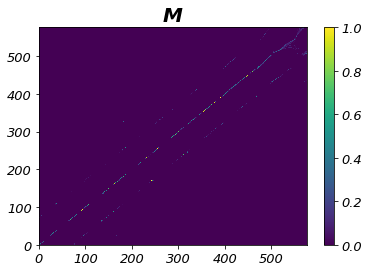

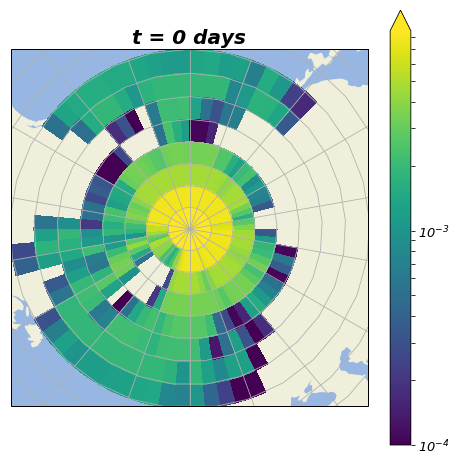

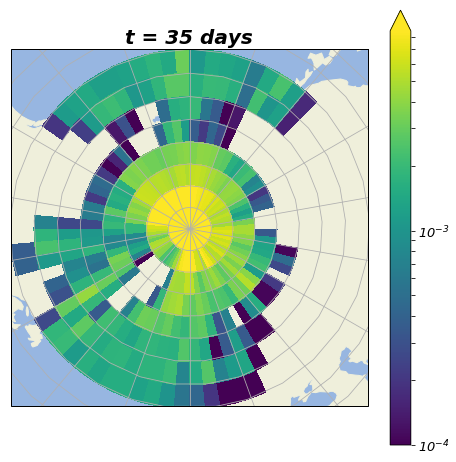

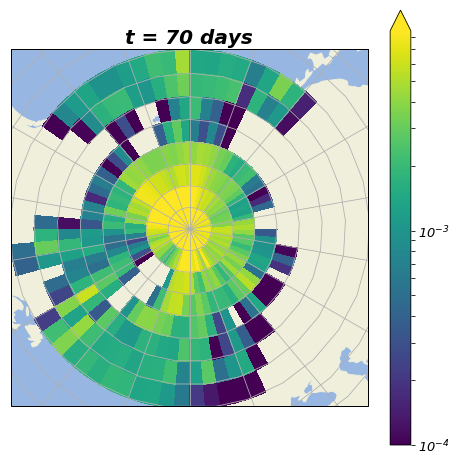

CPU times: user 20.5 s, sys: 72.1 ms, total: 20.5 s
Wall time: 10.1 s


In [52]:
%%time 
%time M, R0, latbins, lonbins = trans_mat([5,5], lon_init, lon_final, lat_init, lat_final)

X,Y = np.meshgrid(lonbins, latbins)
lat_area = area((Y[:-1,:-1]+Y[1:,1:])/2., res)/1e6

plt.figure()
p = plt.pcolormesh(M)
plt.colorbar(p)
plt.title("M")

times = 3
nlat = len(latbins)-1
nlon = len(lonbins)-1

R = np.zeros((times, nlat*nlon))
R[0,:] = R0
R[1,:] = np.dot(M,R[0,:])
R[2,:] = np.dot(M,R[1,:])

vmax = R.max()/np.mean(lat_area)

for t in range(times):
    ax = set_axes()
    p  = ax.pcolormesh(lonbins, latbins, R[t,:].reshape(nlat,nlon)/lat_area, transform = ccrs.PlateCarree(), norm = mpl.colors.LogNorm(vmin=1e-4,vmax=vmax))
    ax.figure.colorbar(p, extend = 'max')
    ax.set_title("t = {} days".format(t*35))
    plt.show()

# Particles everywhere

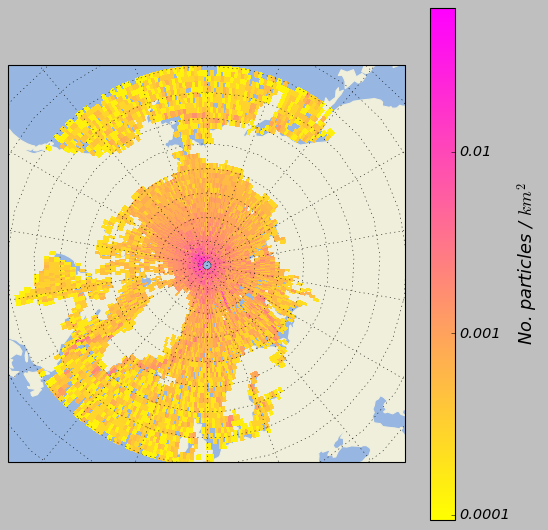

In [58]:

everywhere_try1 = "/scratch/AnnekeV/output/everywhere/run_02_19_npart_17059_start_2014-02-01_simdays_35_AdvectionRK4_ice"
everywhere_try2 = "/scratch/AnnekeV/output/everywhere/run_02_19_npart_867407_start_2014-02-01_simdays_35_AdvectionRK4_ice"

plot_functions.plot_histogram(everywhere_try1, final=True, y_extent=50, save=True, res = 1)
# plot_functions.plot_trajectory_map(everywhere_try1)


# ds = xr.open_dataset(everywhere_try1 + ".nc", decode_times=False)

In [105]:
def histo( lons, lats, res = 1):
    H, xedges, yedges = np.histogram2d(lons, lats, bins=(np.arange(-180,360,res),np.arange(30,90,res)))
    X, Y     = np.meshgrid(xedges, yedges)
    lat_area = area((Y[:-1,:-1]+Y[1:,1:])/2., res)/1e6
    H        = H.T
    H        = H/lat_area # Let each row list bins with common y range.
    return H,X,Y, 1./np.max(lat_area)




# Particles from Norwegian Sea

In [205]:
output_name = advect_glorys_data.run_experiment()


Fieldset is ready

Particle set is ready



No. particles is 1001
Start time is 2014-03-01 
Runtime is 400
Output name is /home/students/6252699/thesis/parcels2/output/run_glorys_02_18_npart_1001_start_2014-03-01_lat_74.0_75.1578979492_simdays_400_AdvectionRK4_ice
Latitude: 74-75



INFO: Compiled Sea_Ice_ParticleAdvectionRK4_iceSample_sitperiodicBCC ==> /tmp/parcels-26525/e5c1d8342486ca5a309d24527084aea4.so
100% (34560000.0 of 34560000.0) |########| Elapsed Time: 0:06:05 Time:  0:06:05


Time elapsed = 456.5 s 


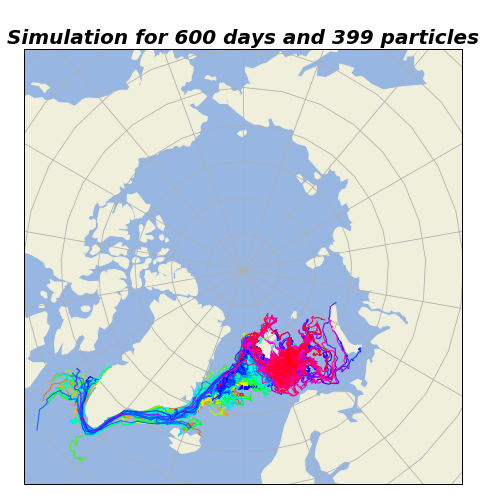

In [189]:
plot_functions.plot_trajectory_map(output_name, scatter=False)

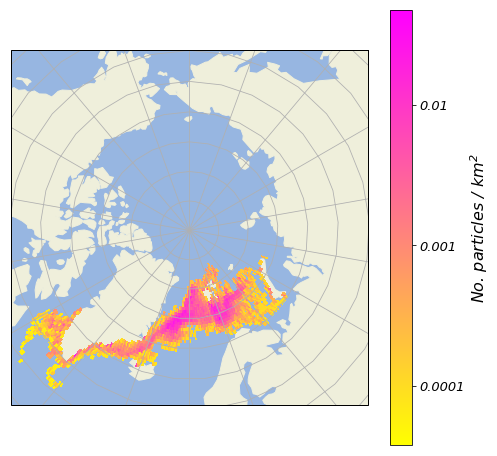

In [188]:
plot_functions.plot_histogram(output_name, res =0.5)

# Particles from Bering strait, but with GLORYS data

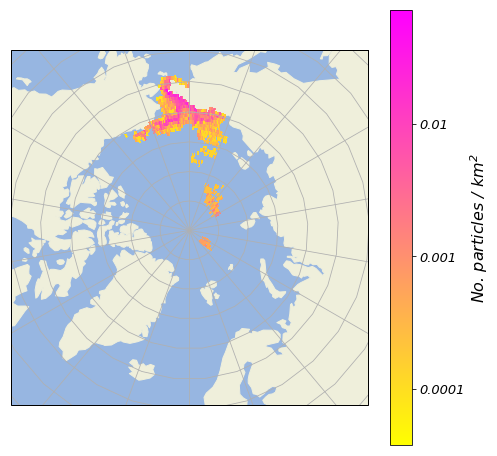

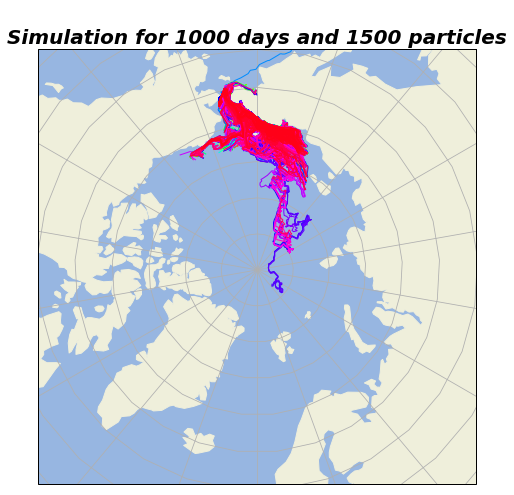

In [216]:


res = 0.5; y_extent = 60

ds = xr.open_dataset("/scratch/AnnekeV/output/run_bering_glorys_02_18_npart_1500_start_2014-02-01_lat_66.0_66.5_simdays_1000_AdvectionRK4_ice" + ".nc", decode_times=False)

lat = ds.lat.values
lon = ds.lon.values

match = re.search(r'\d{4}-\d{2}-\d{2}', ds.time.units)                     #find something date format
start_date  = datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()       #find start date from netcdf file



n_part      = np.size(lat,0)
n_days      = int(np.size(lat,1)*5-5)


H, xedges, yedges = np.histogram2d(lon[:,-20:].flatten(), lat[:,-20:].flatten(), bins=(np.arange(-180,360,res),np.arange(30,90,res)))

X, Y     = np.meshgrid(xedges, yedges)
lat_area = area((Y[:-1,:-1]+Y[1:,1:])/2., res)/1e6
H        = H.T
H        = H/lat_area # Let each row list bins with common y range.

plt.figure(figsize = [8,8])
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.gridlines(xlocs = np.arange(-180,185,20), ylocs = np.arange(-90, 95,5))
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.set_extent([-180,180,y_extent,90],  ccrs.PlateCarree())
vmin, vmax = 1./np.max(lat_area), np.max(H)

im = ax.pcolormesh(X, Y, H, transform = ccrs.PlateCarree(), 
                   norm = mpl.colors.LogNorm(vmin=1/np.max(lat_area),vmax=np.max(H)), 
                   cmap = 'spring_r'
                  )
cbar = ax.figure.colorbar(im)
ticks = [1e-4,1e-3,1e-2,0.1, 1, 5, 10]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.set_label(r"No. particles / $km^2$")

plt.savefig( "/home/students/6252699/thesis/parcels2/figures/" + "histogram_final_simdays_{}_npart_{}_latmin_{:.0f}_{}.png".format(n_days,n_part, np.min(lat[:,0]), start_date))
plt.show()
plot_functions.plot_trajectory_map("/scratch/AnnekeV/output/run_bering_glorys_02_18_npart_1500_start_2014-02-01_lat_66.0_66.5_simdays_1000_AdvectionRK4_ice" )
plt.show()

<xarray.DataArray 'time' (traj: 87, obs: 121)>
array([[23544000., 23976000., 24408000., ..., 74520000., 74952000., 75384000.],
       [23544000., 23976000., 24408000., ..., 74520000., 74952000., 75384000.],
       [23544000., 23976000., 24408000., ..., 74520000., 74952000., 75384000.],
       ...,
       [23544000., 23976000., 24408000., ..., 74520000., 74952000., 75384000.],
       [23544000., 23976000., 24408000., ..., 74520000., 74952000., 75384000.],
       [23544000., 23976000., 24408000., ..., 74520000., 74952000., 75384000.]])
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      
    standard_name:  time
    units:          seconds since 2014-01-01T12:00:00.000000000
    calendar:       np_datetime64
    axis:           T

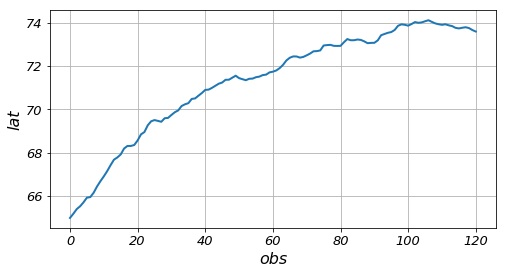

In [182]:
ds = xr.open_dataset(output_name + ".nc", decode_times=False)
ds.lat.mean("traj").plot()
ds.time

# Scratch and notebook

In [4]:
3+6

9

In [29]:
ds = xr.open_dataset(output_name + ".nc", decode_times=False)

(array([1202.,   32.,   39.,   26.,   21.,   30.,   42.,   76.,  116.,
         522.]),
 array([0.        , 0.10000153, 0.20000306, 0.30000457, 0.40000612,
        0.5000076 , 0.60000914, 0.70001066, 0.80001223, 0.90001374,
        1.0000153 ], dtype=float32),
 <a list of 10 Patch objects>)

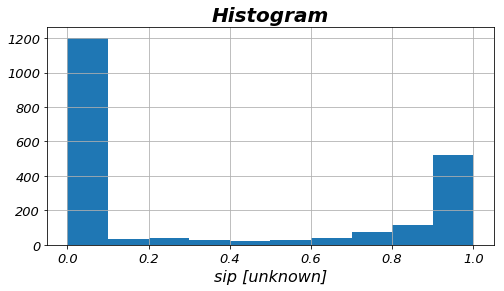

In [36]:
ds.sip.plot.hist()


25
('size var', 275)
('size time', 275)


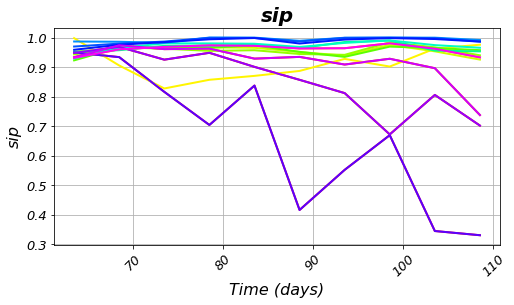

In [12]:
plot_functions.plot_single_variable(f_part=output_name,dt_days=5,variable_name='sip')

In [ ]:
%%time
yr14  = xr.open_mfdataset(filenames['U']['data'])


In [ ]:
yr14.sel(time = '2014-02-01)

In [ ]:

plt.figure(figsize = [40,8])
dates = yr14.time.values
dif_dates = (dates[1:]-dates[:-1])/1e9/86400
type(dif_dates)
plt.plot( dif_dates)
below_zero = np.where(np.array(dif_dates, dtype='int')<1)
print(np.array(below_zero)[0])

print(dates[below_zero])
# below_zero = np.array(below_zero) +1
# print(below_zero)
# print(dates[below_zero])


# for i in below_zero:
#     print(i)
#     filenames['U']['data'][i]
#     filenames['U']['data'][i+1]


In [146]:
res       = '0083'
data_dir  = '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA%s-N006/means/' %res #Directory for nemo data
ifiles    = sorted(glob.glob(data_dir+'ORCA%s-N06_200101??d05I.nc' %res) + glob.glob(data_dir+'ORCA%s-N06_200102??d05I.nc' %res))
ifiles


['/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010105d05I.nc',
 '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010110d05I.nc',
 '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010115d05I.nc',
 '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010120d05I.nc',
 '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010125d05I.nc',
 '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010130d05I.nc',
 '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010204d05I.nc',
 '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010209d05I.nc',
 '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20010214d05I.nc',
 '/data2/imau/oceanparcels/h

In [58]:
dir_glorys = "/scratch/AnnekeV/reanalysis_data/"
!ls



AdvectParticles.py  other			   run.ipynb		  year1
job.sh.e18144	    plotting_functions.pyc	   running_functions.pyc
job.sh.o18144	    __pycache__			   soac
miniconda2	    python-for-lunch-anneke.ipynb  thesis


In [217]:
df = "/scratch/AnnekeV/reanalysis_data/" + "GLOBAL_REANALYSIS_PHY_001_030-TDS_20160301_uv_uvice_con_thick.nc"
ds = xr.open_dataset(df).load()


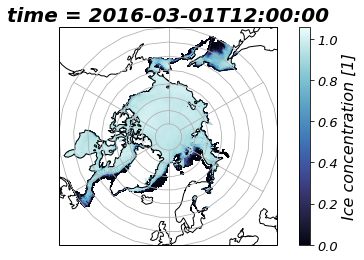

In [223]:
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,50,90],ccrs.PlateCarree()); ax.coastlines(); ax.gridlines(ylocs= [50, 55, 60, 65, 70, 75, 80,85])
ds.siconc.where('siconc'>0.15).plot(ax=ax, transform=ccrs.PlateCarree(), cmap = cmocean.cm.ice)

In [73]:

glorysfiles_aug = sorted(glob.glob(dir_glorys + "GLOBAL_REANALYSIS_PHY_001_030-TDS_201608*_uv_uvice_con_thick.nc" ))
dss_aug = xr.open_mfdataset(glorysfiles_aug).load()

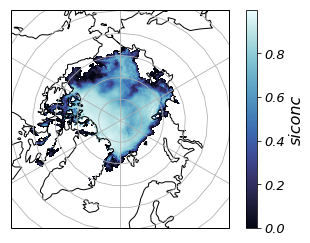

In [74]:
ax = plt.axes(projection=ccrs.NorthPolarStereo()); ax.set_extent([-180,180,60,90],ccrs.PlateCarree()); ax.coastlines(); ax.gridlines()
dss_aug.siconc.mean(dim = "time").plot(ax=ax, transform=ccrs.PlateCarree(), cmap = cmocean.cm.ice)

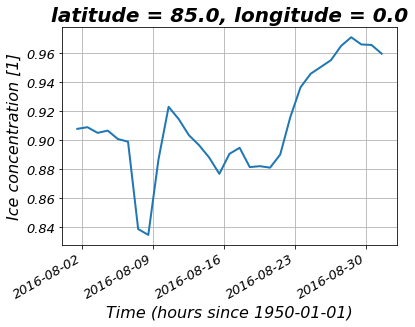

In [76]:
dss_aug.siconc.sel(latitude=85, longitude=0).plot()

In [82]:
%%time
glorysfiles_2016 = sorted(glob.glob(dir_glorys + "GLOBAL_REANALYSIS_PHY_001_030-TDS_2016*_uv_uvice_con_thick.nc" ))

dss_2016 = xr.open_mfdataset(glorysfiles_2016).load()

CPU times: user 6.43 s, sys: 6.77 s, total: 13.2 s
Wall time: 3.7 s


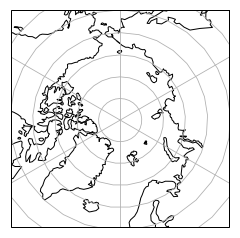

In [95]:
%%time
ax = plt.axes(projection=ccrs.NorthPolarStereo()); ax.set_extent([-180,180,60,90],ccrs.PlateCarree()); ax.coastlines(); ax.gridlines()
mean_ice = dss_2016.sithick.mean("time")
no_zero_mean_ice = mean_ice.where(mean_ice<1e12,-999)



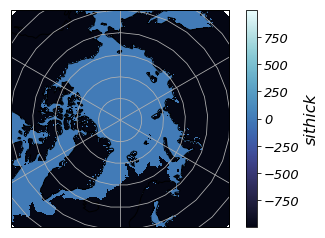

In [98]:
ax = plt.axes(projection=ccrs.NorthPolarStereo()); ax.set_extent([-180,180,60,90],ccrs.PlateCarree()); ax.coastlines(); ax.gridlines()

no_zero_mean_ice.plot(ax=ax, transform=ccrs.PlateCarree(), cmap =cmocean.cm.ice, robust=True)

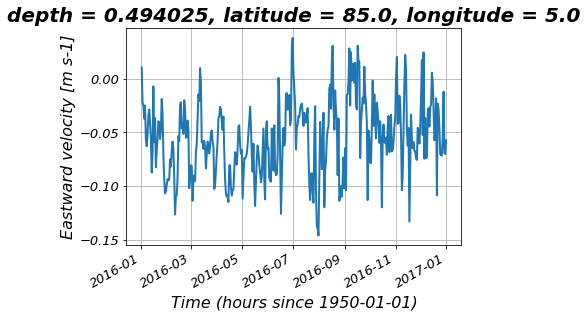

In [81]:
dss_2016.uo.sel(latitude =85, longitude =5).plot()

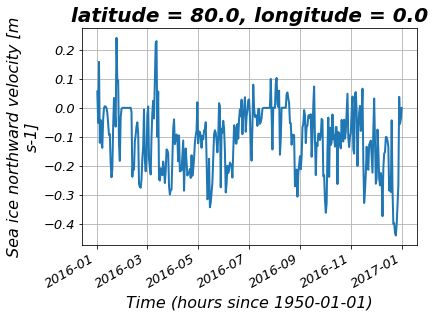

In [99]:
dss_2016.vsi.sel(longitude=0, latitude=80).plot()


In [101]:
%%time
glorysfiles = sorted(glob.glob(dir_glorys + "GLOBAL_REANALYSIS_PHY_001_030-TDS_20*_uv_uvice_con_thick.nc" ))
dss         = xr.open_mfdataset(glorysfiles)


CPU times: user 24.5 s, sys: 735 ms, total: 25.2 s
Wall time: 24.9 s


CPU times: user 4.46 s, sys: 2.12 s, total: 6.58 s
Wall time: 6.76 s


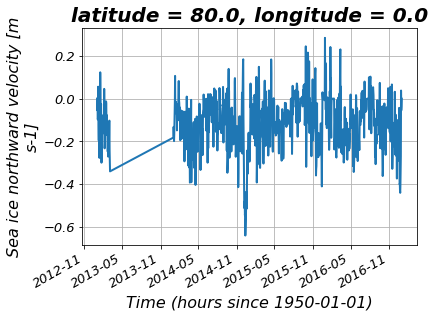

In [102]:
%%time

dss.vsi.sel(longitude=0, latitude=80).plot()

CPU times: user 8.8 s, sys: 5.3 s, total: 14.1 s
Wall time: 9.13 s


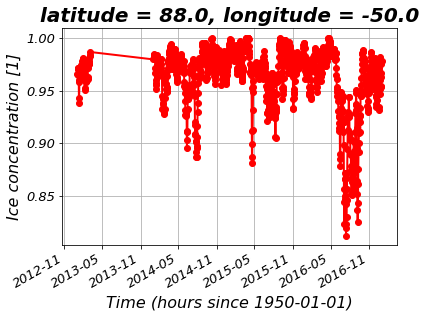

In [115]:
%%time

dss.siconc.sel(longitude = -50, latitude = 88).plot.line(marker = 'o' , color = 'red')

print(dss.siconc.sel(longitude = -50, latitude = 88).values)

In [135]:
%%time


all_glorys = []
for year in [2014, 2015, 2016]:
    all_glorys.append(glob.glob(dir_glorys + "GLOBAL_REANALYSIS_PHY_001_030-TDS_{:d}*_uv_uvice_con_thick.nc".format(year) )) 
all_glorys = sorted(all_glorys)
# dss_2013         = xr.open_mfdataset(glorysfiles_2013)
#     for i in range(len(glorysfiles_2013)): print(glorysfiles_2013[i])


CPU times: user 3.75 ms, sys: 10.5 ms, total: 14.2 ms
Wall time: 12.7 ms


In [ ]:
# data_dir  = "/scratch/AnnekeV/reanalysis_data/" + "GLOBAL_REANALYSIS_PHY_001_030-TDS_201608*_uv_uvice_con_thick.nc" #Directory for nemo data dwonladed
# ifiles    = sorted(glob.glob(data_dir))

# xr.open_mfdataset(ifiles)

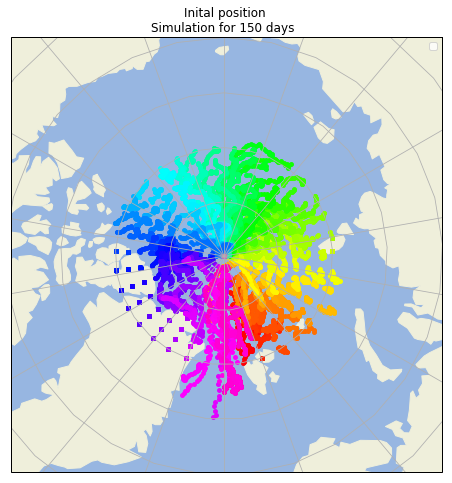

In [28]:
plot_functions.plot_output_scatter(file_dir = "/home/students/6252699/thesis/parcels2/output/run_01_29_npart_360_start_2001-08-01_lat_80.0_90.0_simdays_150_AdvectionRK4_ocean")

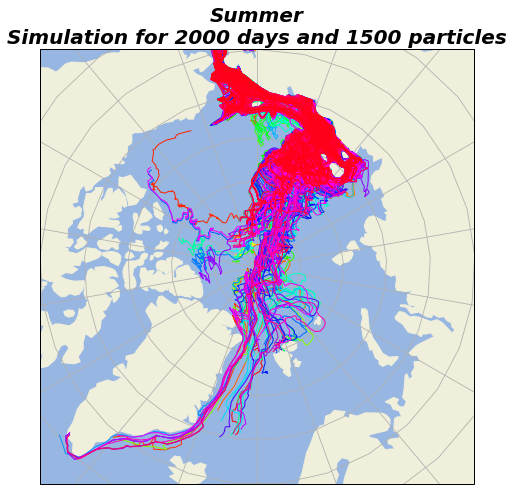

In [7]:
%matplotlib inline
datadir = "/scratch/AnnekeV/output/"
fname_summer   = "run_02_07_bering_npart_1500_start_2001-08-01_lat_66.0_66.5_simdays_2000_AdvectionRK4_ice"
plot_functions.plot_trajectory_map(datadir + fname, y_extent=65, extra_title="Summer")




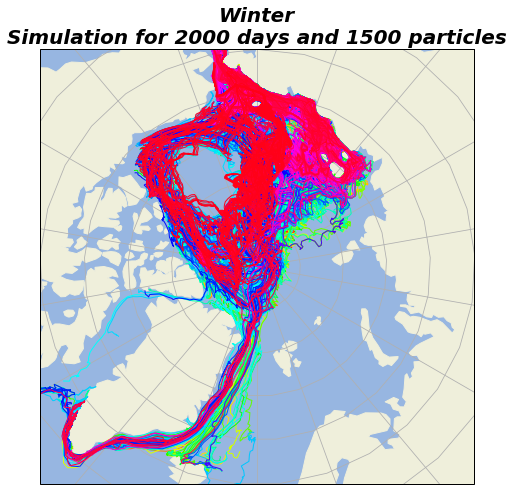

In [10]:

fname_winter   = "run_02_09_bering_npart_1500_start_2001-02-01_lat_66.0_66.5_simdays_2000_AdvectionRK4_ice"
plot_functions.plot_trajectory_map(datadir + fname_winter, y_extent=65, extra_title="Winter")


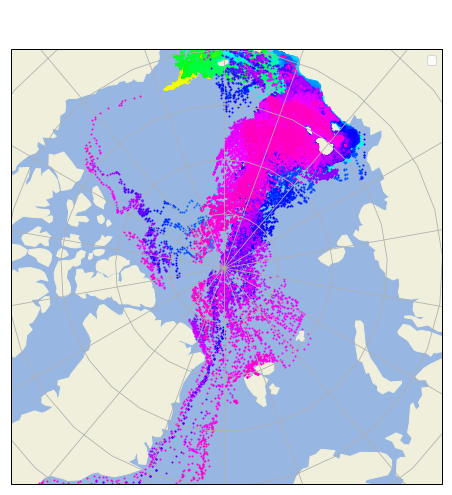

In [7]:
%time plot_functions.plot_output_scatter(datadir + fname, satellite_height= 2e8)

CPU times: user 15 s, sys: 110 ms, total: 15.1 s
Wall time: 1.33 s


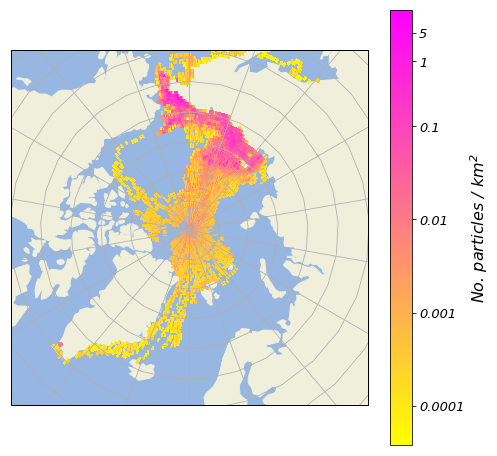

In [9]:
%time plot_functions.plot_histogram(datadir + fname, y_extent=60, res = 0.5)

CPU times: user 13.3 s, sys: 125 ms, total: 13.4 s
Wall time: 1.17 s


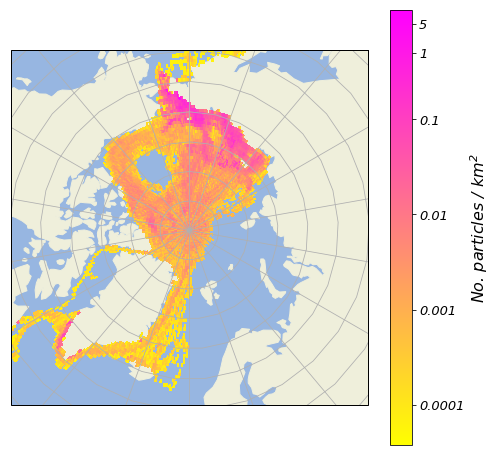

In [11]:
%time plot_functions.plot_histogram(datadir + fname_winter, y_extent=60, res = 0.5)

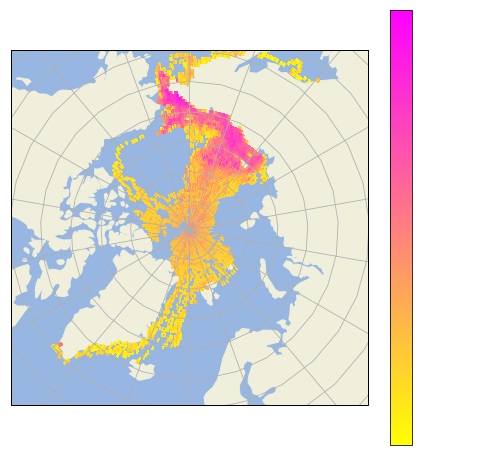

In [102]:
import netCDF4 as netcdf
from functions.grid_to_km import area
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

file_dir= datadir + fname; y_extent = 60; res =0.5
'''plot a histogram, res is resolution of the pcolormesh, histogram'''

'''Import data'''
test = netcdf.Dataset(file_dir + ".nc")
lat = test['lat'][:,:]
lon  = test['lon'][:,:]
test.close()

H, xedges, yedges = np.histogram2d(lon.flatten(), lat.flatten(), bins=(np.arange(0,360,res),np.arange(30,90,res)))

X, Y     = np.meshgrid(xedges, yedges)
lat_area = area((Y[:-1,:-1]+Y[1:,1:])/2., res)/1e6
H        = H.T
H        = H/lat_area # Let each row list bins with common y range.

plt.figure(figsize = [8,8])
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.gridlines(xlocs = np.arange(-180,185,20), ylocs = np.arange(-90, 95,5))
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.set_extent([-180,180,y_extent,90],  ccrs.PlateCarree())

vmin, vmax = 1./np.max(lat_area), np.max(H)


im = ax.pcolormesh(X, Y, H, transform = ccrs.PlateCarree(), 
                   norm = mpl.colors.LogNorm(vmin=1/np.max(lat_area),vmax=np.max(H)), 
#                    vmin = vmin,
#                    vmax = vmax,
                   cmap = 'spring_r'
                  )
cbar = ax.figure.colorbar(im)
ticks = [1e-4,1e-3,1e-2,0.1, 1, 5, 10]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.set_label(r"No. particles / $km^2$")

plt.show()


In [73]:
mean_lat = (Y[:-1,:-1]+Y[1:,1:])/2.
print(mean_lat)
Y.astype(float)


[[30.5 30.5 30.5 ... 30.5 30.5 30.5]
 [31.5 31.5 31.5 ... 31.5 31.5 31.5]
 [32.5 32.5 32.5 ... 32.5 32.5 32.5]
 ...
 [86.5 86.5 86.5 ... 86.5 86.5 86.5]
 [87.5 87.5 87.5 ... 87.5 87.5 87.5]
 [88.5 88.5 88.5 ... 88.5 88.5 88.5]]


array([[30., 30., 30., ..., 30., 30., 30.],
       [31., 31., 31., ..., 31., 31., 31.],
       [32., 32., 32., ..., 32., 32., 32.],
       ...,
       [87., 87., 87., ..., 87., 87., 87.],
       [88., 88., 88., ..., 88., 88., 88.],
       [89., 89., 89., ..., 89., 89., 89.]])